# Computationally-feasible uncertainty quantification in model-based landslide risk assessment

Anil Yildiz\,$^{1,*}$, Hu Zhao\,$^{1}$ and Julia Kowalski\,$^{1}$

$^1$ Methods for Model-based Development in Computational Engineering, RWTH Aachen University, Aachen, Germany

$^*$ yildiz@mbd.rwth-aachen.de

In [1]:
%%bash

curl -sSL https://install.python-poetry.org | python3 -
poetry install

<3>WSL (17) ERROR: CreateProcessEntryCommon:370: getpwuid(0) failed 2
<3>WSL (17) ERROR: CreateProcessEntryCommon:374: getpwuid(0) failed 2
<3>WSL (17) ERROR: CreateProcessEntryCommon:577: execvpe /bin/bash failed 2
<3>WSL (17) ERROR: CreateProcessEntryCommon:586: Create process not expected to return


CalledProcessError: Command 'b'\ncurl -sSL https://install.python-poetry.org | python3 -\npoetry install\n'' returned non-zero exit status 1.

## Abstract

**Introduction** Increasing complexity and capacity of computational physics-based landslide run-out modelling yielded highly efficient model-based decision support tools, e.g. landslide susceptibility or run-out maps, or geohazard risk assessments. A reliable, robust and reproducible development of such tools requires a thorough quantification of uncertainties, which are present in every step of computational workflow from input data, such as topography or release zone, to modelling framework used, e.g. numerical error. **Methodology** Well-established methods from reliability analysis such as Point Estimate Method (PEM) or Monte Carlo Simulations (MCS) can be used to investigate the uncertainty of model outputs. While PEM requires less computational resources, it does not capture all the details of the uncertain output. MCS tackles this problem, but creates a computational bottleneck. A comparative study is presented herein by conducting multiple forward simulations of landslide run-out for a synthetic and a real-world test case, which are used to construct Gaussian process emulators as a surrogate model to facilitate high-throughput tasks. **Results** It was demonstrated that PEM and MCS provide similar expectancies, while the variance and skewness differ, in terms of post-processed scalar outputs, such as impact area or a point-wise flow height. Spatial distribution of the flow height was clearly affected by the choice of method used in uncertainty quantification. **Discussion** If only expectancies are to be assessed then one can work with computationally-cheap PEM, yet MCS has to be used when higher order moments are needed. In that case physics-based machine learning techniques, such as Gaussian process emulation, provide strategies to tackle the computational bottleneck. It can be further suggested that computational-feasibility of MCS used in landslide risk assessment can be significantly improved by using surrogate modelling. It should also be noted that the gain in compute time by using Gaussian process emulation critically depends on the computational effort needed to produce the training dataset for emulation by conducting simulations.


## Introduction

Computational landslide run-out models can predict the spatial evolution of depth and velocity of the failed mass, which is crucial for landslide risk assessment and mitigation, especially for flow-like landslides due to their rapid nature ([Cepeda, 2013](https://www.cfms-sols.org/sites/default/files/Actes/2157-2160.pdf); [McDougall, 2017](dx.doi.org/10.1139/cgj-2016-0104)). Utilising computational landslide run-out models for model-based decision support requires a well-defined, transparent and modular setup of the complete computational value-chain. Such a chain consists of many links, including a digital representation of the topography, the underlying physics-based process model, a numerical solution scheme, the approach to parameter calibration along with the training data it relies on, and concepts used for sensitivity analyses and uncertainty quantification. Challenges in the technical realisation of such integrated workflows have been successfully addressed in the past ([Dalbey, 2008](https://doi.org/10.1029/2006JB004471); [Aaron et al., 2019](https://doi.org/10.1007/s10346-018-1116-8); [Sun et al., 2021](https://doi.org/10.1007/s10346-021-01619-3); [Aaron et al., 2022](https://doi.org/10.1007/s10346-022-01939-y); [Zhao et al., 2022](https://doi.org/10.1007/s10346-022-01857-z)). It will be of crucial importance in the future to increase the efficiency, sustainability and, hence, acceptance of such orchestrated workflows for landslide risk assessment by improving their robustness, reliability and computational-feasibility.

It will be particularly important to assess the reliability of landslide risk assessment by quantifying and managing uncertainties throughout the workflow. This is a challenging task, which requires to consider and structure the *landscape of uncertainties* affecting various steps of the decision-making process. Relevant uncertainty originates from  uncertain model input - such as the digital elevation model representing the topography ([Zhao and Kowalski, 2020](https://doi.org/10.5194/nhess-20-1441-2020)) or release area and volume - and rheological parameters ([Quan Luna et al., 2013](https://doi.org/10.1007/978-3-642-31310-3_42)). Furthermore, process uncertainty can result from numerical modelling schemes ([Schraml et al., 2015](https://doi.org/10.5194/nhess-15-1483-2015)) or calibration methods ([Aaron et al., 2019](https://doi.org/10.1007/s10346-018-1116-8); [Aaron et al., 2022](https://doi.org/10.1007/s10346-022-01939-y)). All relevant uncertainties in the computational workflow include aleatoric aspects due to the intrinsic randomness of the process, as well as epistemic uncertainty that is of systemic nature, and might be due to a lack of data. A comprehensive, integrated uncertainty analysis within a georisk assessment framework is an important reminder of the limitations of the knowledge about processes involved, and the need to improve data collection and quality ([Eidsvig et al.,2014](https://doi.org/10.1016/j.enggeo.2014.08.006)).

Different methods of reliability analysis have been used in the recent decades both in geohazards research and its practical implementation, to assess the output uncertainty in landslide run-out models due to uncertain input parameters, or to quantify the uncertainty of derived metrics such as the Factor of Safety (FoS). Point Estimate Method (PEM) ([Przewlocki et al., 2019](https://doi.org/10.1088/1757-899X/471/4/042003)), First Order Second Moment method (FOSM) ([Kaynia et al. (2008)](https://doi.org/10.1016/j.enggeo.2008.03.008)), First Order Reliability Method (FORM) [Sun et al. (2021)](https://doi.org/10.1007/s10346-020-01545-w), and Monte Carlo Simulations (MCS) ([Cepeda, 2013](https://www.cfms-sols.org/sites/default/files/Actes/2157-2160.pdf); [Liu et al. (2019)](https://doi.org/10.1016/j.compgeo.2019.03.022); [Brezzi et al. (2021)](https://doi.org/10.1088/1755-1315/833/1/012130)) are examples of such methods. [Dalbey et al., 2008](https://doi.org/10.1029/2006JB004471) presented several standard and new methods for characterising the effect of input data uncertainty on model output for hazardous geophysical mass flows.

PEM is a simple way to determine the expectation (mean), variance, and skewness of a variable that depends on a random input, by evaluating the function at a low number of pre-selected values. Additionally, MCS grants access to the complete probability distribution even in complex problems ([Fenton and Griffiths, 2008](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470284704)). However, it requires a large number of model evaluations, so-called realisations, at randomly selected inputs following a pre-determined statistical distribution. [Przewlocki et al. (2019)](https://doi.org/10.1088/1757-899X/471/4/042003)} used PEM to conduct a probabilistic slope stability analysis of a sea cliff in Poland, and compared the moment estimates with results from MSC. Mean and standard deviation values of FoS yielded similar results, and PEM was favoured as it required a lower number of model realisations, hence lower computational costs for a seemingly similar information outcome. [Tsai et al. (2015)](https://doi.org/10.1007/s12665-014-3696-5)} also obtained similar estimations by comparing PEM and MSC, but pointed out the effects of correlation between input variables. Earlier works also highlighted the limited feasibility of PEM for an increasing number of input variables, as $2^n$ estimations are required for $n$ input variables ([Christian and Baecher, 1999](https://doi.org/10.1061/(asce)1090-0241(1999)125:9(779)); [Christian and Baecher, 2002](https://doi.org/10.1002/nag.256)). Therefore, it is more feasible to handle problems characterised by a low-dimensional input parameter space with PEM, while high-dimensional problems quickly become computationally infeasible.

MCS has also been widely used for practical uncertainty quantification owing to its simplicity of implementation. [Liu et al. (2019)](https://doi.org/10.1016/j.compgeo.2019.03.022) and [Ma et al. (2022)](https://doi.org/10.1007/s10346-021-01795-2) used MCS to quantify uncertainty in landslide run-out distance due to uncertain soil properties. [Brezzi et al. (2021)](https://doi.org/10.1088/1755-1315/833/1/012130) performed uncertainty quantification of the Sant'Andrea landslide using MCS. They assumed the two friction parameters (Coulomb friction and turbulent friction) in a depth-averaged Voellmy-Salm type approach to follow independent Gaussian distributions, and then studied the induced uncertainty in deposit heights. The major challenge of using MCS for uncertainty quantification in landslide run-out modelling is the high computational cost, as pointed out by many researchers ([Dalbey et al., 2008](https://doi.org/10.1029/2006JB004471); [McDougall, 2017](https://doi.org/10.1139/cgj-2016-0104); [Aaron et al., 2022](https://doi.org/10.1007/s10346-022-01939-y); [Zhao and Kowalski, 2022](https://doi.org/10.1007/s10346-022-01857-z)).

As PEM relies on a much lower number of sampling points compared to MCS, the probability distribution function (PDF) of the output cannot be reliably approximated for a general non-linear process model, such as a landslide run-out model in complex topography. MCS provides an approximation of the PDF, but it creates a computational bottleneck when the forward-model is complex and subject to long runtimes. Physics-based machine learning, i.e. creating a surrogate by training a data-driven model with results from a physics-based simulation, can overcome the computational bottleneck of  highly-throughput tasks such as uncertainty quantification. The surrogate model can be sampled, instead of the sampling from the forward model, and hence the PDF of the quantity of interest can be calculated efficiently. An example of physics-based machine learning techniques proven to be effective in many applications related to geohazards is Gaussian Process Emulation, with successful demonstrations in landslide run-out models ([Zhao et al. 2021](https://doi.org/10.1007/s10346-021-01690-w), [Zhao and Kowalski, 2022](https://doi.org/10.1007/s10346-022-01857-z)) and stability of infrastructure slopes ([Svalova et al., 2021](https://doi.org/10.1017/dce.2021.14)).

This study aims at demonstrating how an uncertainty quantification workflow can be set up effectively, and how this affects the model-based landslide risk assessment. A test case with a synthetic topography and a test case with a real world problem are designed. Multiple forward simulations of both cases are conducted to construct Gaussian process emulators to facilitate MCS. The objectives are (i) comparing the results of PEM-based  simulations and MCS conducted with emulators trained based on datasets from a limited number of simulations in terms of three moments, (ii) investigating the effects of topographic complexity, i.e. synthetic topography vs. the topography of a real-world problem, on the PEM - MCS comparison, and (iii) demonstrating the applicability of emulation techniques for uncertainty quantification.

## Materials and Methods

### Modelling approach

Existing physics-based landslide run-out models can be divided into three groups: lumped mass models, particle models, and continuum models. Lumped mass models treat the flow mass as a condensed mass point without spatial variation. This process idealisation greatly reduces the complexity of the problem, but the trade-off is losing spatial variation of flow dynamics, such as internal deformation of the flowing mass. Particle models treat the flow mass as an assembly of particles and simulate the movement of each particle and their interactions in order to characterise flow dynamics. They can directly account for three-dimensional flow behaviours, including an internal re-distribution of mass. Computational realisation of a particle model relies on the definition of conceptual particles, whose size is chosen based on available computational resources, and is often much larger than actual material particles in the landslide. This is beneficial from an implementation point of view, yet requires special attention, when formulating necessary interaction forces which are often challenging to justify and validate. Continuum models treat the flow mass as continuum material, for which governing equations are derived from balance laws closed by tailored, complex constitutive relations. Implementing these in a general three-dimensional context is very challenging and uses a lot of computational resources. A majority of particularly relevant continuum models for practical landslide run-out modelling are formulated within a depth-averaging framework. Depth-averaged continuum models balance computational efficiency, accuracy and interpretability. They can account for internal deformation of the flow material, and provide spatial variation of flow dynamics. Equations 1 - 3 describe the governing system of an idealised depth-averaged landslide run-out model:
$$
\partial_th + \partial_x(hu_x) + \partial_y(hu_y) = 0, \\
\partial_t(hu_x) + \partial_x \left( hu^{2}_x + g_n  \frac{h^2}{2} \right) + \partial_y \left( hu_x u_y \right) = g_x h - S_{fx},\\
\partial_t(hu_y) + \partial_x (hu_xu_y) + \partial_y \left( hu^{2}_y + g_n \frac{h^2}{2} \right) = g_yh - S_{fy}.
$$
The equations are derived from the mass balance (equation 1) and momentum balance (equations 2 and 3). The flow height $h$ and the depth-averaged surface tangent flow velocities $u_{x}$ and $u_{y}$ are the state variables. $g_x$, $g_y$, and $g_n$ are components of the gravitational acceleration along surface tangent and in normal directions. The friction terms $S_{fx}$ and $S_{fy}$ depend on the chosen basal rheology. In terms of the Voellmy rheological model, they are defined as:
$$
S_{fi} = \frac{u_{i}}{\left \| \mathbf{u} \right\|} (\mu g_{n}h + \frac{g}{\xi}{ \left \| \mathbf{u} \right\|}^2 ),\quad i \in \{x,y\},
$$
where $\|\mathbf{u}\|$ denotes the magnitude of the flow velocity; $\mu$ and $\xi$ are the dry-Coulomb friction coefficient and turbulent friction coefficient respectively.

Many numerical solvers for depth-averaged landslide run-out models have been developed in the past decades, and [McDougall (2017)](https://doi.org/10.1139/cgj-2016-0104) provides a comprehensive review. A GIS-based open source computational tool developed by [Mergili et al. (2017)](https://doi.org/10.5194/gmd-10-553-2017), r.avaflow v2.3,  is used in this study. It implements a high-resolution total variation diminishing non-oscillatory central differencing scheme to solve equations 1 - 4 given topographic data, initial mass distribution, and Voellmy parameters. It runs on Linux systems, and employs the GRASS GIS software, together with the programming languages Python and C, and the statistical software R. A Digital Elevation Model (DEM) and a release height map are given as input as raster files.

### Case studies

#### Synthetic case

A simple topography has been created in Python - similar to the topography generation in AvaFrame ([D’Amboise et al., 2022](https://doi.org/10.5194/gmd-15-2423-2022)) - which is denoted as *synthetic case* herein. Topography consists of a parabolic slope starting at $x=0$ at an altitude of 1332 m, and connecting to a flat land at $x=3000$ at an altitude of 0 m. Extent of the area in $x$ and $y$ directions are 5000 m and 4000 m, respectively, whereas the resolution is 20 m. Release zone was defined as an elliptic cylinder, of which the centre is located at $ \left ( x,y \right ) = $ (600, 2000) with a minor axis of 100 m and a major axis of 200 m. Height at each point within the ellipse was defined as 20 m, which generates a total release volume of 1.432 x $10^6$ $m^3$. Figure 1A illustrates the maximum flow height map from a simulation of synthetic case, while figure 1B shows the deposit height from the same simulation.

c:\Users\anilyildiz\miniconda3\envs\yildizetal2022\lib\site-packages\ipykernel_launcher.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


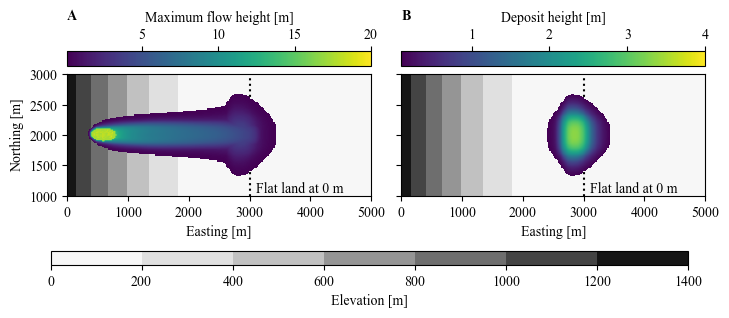

In [ ]:
# plotting figure 1

from frontiers_yildizetal.ravaflow import Simulations
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from pkg_resources import resource_filename
import matplotlib as mpl

synth = Simulations('synth')

path = 'files/raster/elev.tif'
dem_path = resource_filename('frontiers_yildizetal', path)

with rasterio.open(dem_path, 'r') as src:
    dem = src.read(1)
with rasterio.open(synth.data_import.raster_link('hmax'), 'r') as src:
    hmax = src.read(1)
    hmax_ma = np.ma.masked_where(hmax < 0.1, hmax, copy=True)
with rasterio.open(synth.data_import.raster_link('hfin'), 'r') as src:
    hfin = src.read(1)
    hfin_ma = np.ma.masked_where(hfin < 0.1, hfin, copy=True)

cmap = mpl.cm.Greys
norm = mpl.colors.Normalize(vmin=0, vmax=1400)

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)

c_topo = ax1.contourf(
    dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400
)
ax1.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyles='dotted')
c1 = ax1.imshow(
    hmax_ma, cmap='viridis', extent=[0, 5000, 0, 4000], zorder=1, vmin=0.1, vmax=20
)
fig.colorbar(
    c1, ax=ax1, location='top', orientation='horizontal', label='Maximum flow height [m]'
)

fig.subplots_adjust(bottom=0.5)
cbar_ax = fig.add_axes([0.05, 0, 0.90, 0.05])
fig.colorbar(
    c_topo,
    cax=cbar_ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal',
    label='Elevation [m]',
    shrink=0.36,
)

ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_xticks(np.arange(0, 5001, 1000))
ax1.set_yticks(np.arange(0, 5001, 500))
ax1.set_xlim(0, 5000)
ax1.set_ylim(1000, 3000)
ax1.text(0, 3900, 'A', weight='bold')
ax1.text(3100, 1000, 'Flat land at 0 m', ha='left', va='bottom')

ax2.contourf(dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400)
ax2.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyle='dotted')
c2 = ax2.imshow(hfin_ma, cmap='viridis', extent=[0, 5000, 0, 4000], zorder=1, vmin=0.1, vmax=4)
fig.colorbar(c2, ax=ax2, location='top', orientation='horizontal', label='Deposit height [m]')

ax2.set_xlabel('Easting [m]')
ax2.set_xticks(np.arange(0, 5001, 1000))
ax2.set_yticks(np.arange(0, 5001, 500), labels=None)
ax2.set_xlim(0, 5000)
ax2.set_ylim(1000, 3000)
ax2.axes.get_yaxis().set_ticklabels([])
ax2.text(0, 3900, 'B', weight='bold')
ax2.text(3100, 1000, 'Flat land at 0 m', ha='left', va='bottom')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = [18 / 2.54, 7 / 2.54]
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

fig.set_rasterized(True)
ax1.set_rasterized(True)
ax2.set_rasterized(True)

**Figure 1:** (A) Maximum flow height and (B) deposit height from a simulation of the synthetic case.

#### Acheron rock avalanche

A real-world case is chosen to compare the differences in uncertainty quantification with the synthetic case. Radiocarbon testing dates the occurrence of Acheron rock avalanche - located near Canterbury, New Zealand - approximately 1100 years before present, and it may have been triggered by seismic activity ([Smith et al., 2006](https://doi.org/10.1007/s10346-005-0012-1)). The deposit area was estimated to be 0.72 x $10^6$ $m^2$ using a GPS outline of the deposit , while the deposit volume was estimated as 8.9 x $10^6$ $m^3$ using an estimated mean depth derived from observed and estimated thicknesses for different morphological zones ([Smith et al., 2012](https://doi.org/10.1080/00288306.2012.733947)). DEM file and the release height map are obtained from Mergili and Pudasaini ([2014-2021 - r.avaflow - The mass flow simulation tool](https://www.avaflow.org) - Accessed on 2022-07-12), which gives an initial release volume of 6.4 x $10^6$ $m^3$. Figure 2 presents the shaded relief of the area, together with a map of maximum flow height (see figure 2A) and deposit height (see figure 2B) from a random simulation of Acheron rock avalanche.

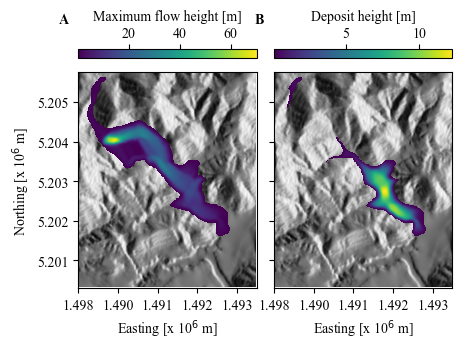

In [ ]:
# plotting figure 2

from frontiers_yildizetal.ravaflow import Simulations
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from pkg_resources import resource_filename
import matplotlib as mpl
from rasterio.plot import plotting_extent

ac = Simulations('acheron')

path = 'files/raster/hillshade_acheron.tif'
hill_path = resource_filename('frontiers_yildizetal', path)

with rasterio.open(hill_path, 'r') as hill:
    hill_arr = hill.read(1)
    hill_ma = np.ma.masked_where(hill_arr < -30000, hill_arr, copy=True)
with rasterio.open(ac.data_import.raster_link('hmax'), 'r') as src:
    hmax = src.read(1)
    hmax_ma = np.ma.masked_where(hmax < 0.1, hmax, copy=True)
with rasterio.open(ac.data_import.raster_link('hfin'), 'r') as src2:
    hfin = src2.read(1)
    hfin_ma = np.ma.masked_where(hfin < 0.1, hfin, copy=True)

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 1]})

ax1.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c1 = ax1.imshow(hmax_ma, cmap='viridis', extent=plotting_extent(hill), zorder=1)
fig.colorbar(
    c1,
    ax=ax1,
    location='top',
    orientation='horizontal',
    label='Maximum flow height [m]',
    shrink=1,
)

ax1.set_xlabel('Easting [x 10$^6$ m]')
ax1.set_ylabel('Northing [x 10$^6$ m]')
ax1.set_xticks(
    ticks=np.arange(1489000, 1493600, 1000), labels=[1.498, '1.490', 1.491, 1.492, 1.493]
)
ax1.set_yticks(
    ticks=np.arange(5201000, 5205001, 1000), labels=[5.201, 5.202, 5.203, 5.204, 5.205]
)
ax1.text(1488500, 5207000, 'A', weight='bold')

ax2.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c2 = ax2.imshow(hfin_ma, cmap='viridis', extent=plotting_extent(hill), zorder=1)
fig.colorbar(
    c2, ax=ax2, location='top', orientation='horizontal', label='Deposit height [m]', shrink=1
)

ax2.set_xlabel('Easting [x 10$^6$ m]')
ax2.set_xticks(
    ticks=np.arange(1489000, 1493600, 1000), labels=[1.498, '1.490', 1.491, 1.492, 1.493]
)
ax2.axes.get_yaxis().set_ticklabels([])
ax2.text(1488500, 5207000, 'B', weight='bold')

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = [12 / 2.54, 9 / 2.54]
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

**Figure 2:** (A) Maximum flow height and (B) deposit height from a simulation of Acheron rock avalanche.

#### Gaussian process emulation

The main problem of applying MCS for uncertainty quantification in landslide run-out modelling is its high computational cost. The runtime of the landslide run-out model is one of the key drivers of computational cost in classical MCS, as it scales with the number of forward evaluations. 
Gaussian process emulation has been used in recent years to build cheap-to-evaluate emulators to replace expensive-to-evaluate computational models in the framework of uncertainty quantification, such as [Sun et al. (2021b)](https://doi.org/10.1016/j.enggeo.2020.105950), [Zeng et al. (2021)](https://doi.org/10.1016/j.enggeo.2021.106303), and [Zhao and Kowalski (2022)](https://doi.org/10.1007/s10346-022-01857-z). A Gaussian process emulator is a statistical approximation of a simulation model, built based on input and output data of a small number of simulation runs. Once an emulator is constructed, it provides prediction of simulation output at a new input point almost instantly, together with an assessment of the prediction uncertainty. This emulator-induced uncertainty can be taken into account in the framework of uncertainty quantification.

Let $y=f(\mathbf{x})$ denote a simulator where $y$ represents a scalar output depending on a $p$-dimensional input $\mathbf{x}$. Assuming that the simulator is a realisation of a Gaussian process with a mean function $m(\cdot)$ and a kernel function $k(\cdot,\cdot)$, namely
$$
f(\cdot) \sim \mathcal{N}(m(\cdot), k(\cdot,\cdot))
$$
a Gaussian process emulator can be built based on the input-output data $\mathcal{D}$ of $n$ simulation runs, namely $\mathcal{D}=\{\mathbf{x}_i, y_i\}_{i=1}^{n}$. At any new input point $\mathbf{x}^\ast$, the approximated output $y^\ast$ follows a Gaussian distribution given by
$$
y^\ast  \sim  \mathcal{N}
\left(m^{\prime}(\mathbf{x}^\ast), k^{\prime}(\mathbf{x}^\ast,\mathbf{x}^\ast) \right), \\
m^{\prime}(\mathbf{x}^\ast)=m(\mathbf{x}^\ast) +\mathbf{k}^T(\mathbf{x}^\ast) \mathbf{K}^{-1} \left(y_1-m(\mathbf{x}_1), \ldots, y_n-m(\mathbf{x}_n) \right)^T, \\
k^{\prime}(\mathbf{x}^\ast,\mathbf{x}^\ast) = k(\mathbf{x}^\ast,\mathbf{x}^\ast)-\mathbf{k}^T(\mathbf{x}^\ast) \mathbf{K}^{-1} \mathbf{k}(\mathbf{x}^\ast). 
$$
The symbol $\mathbf{K}$ denotes the $n \times n$ covariance matrix of which the $(i,j)$-th entry $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)$ and the symbol $\mathbf{k}(\mathbf{x}^\ast)=\left[k(\mathbf{x}^\ast,\mathbf{x}_1), \ldots, k(\mathbf{x}^\ast,\mathbf{x}_n) \right]^T$.

*RobustGaSP* package developed by [Gu et al. (2019)](https://doi.org/10.32614/RJ-2019-011) is used in this study to build emulators. It provides robust Gaussian process emulation for both single-variate ([Gu et al., 2018](https://doi.org/10.1214/17-AOS1648)), i.e. one simulation producing one scalar output, and multi-variate simulators ([Gu and Berger, 2016](https://doi.org/10.1214/16-AOAS934)), i.e. one simulation producing high-dimensional output. Training and validation datasets of each case were generated from outputs of both cases simulated with r.avaflow 2.3. 100 simulations for training, and 20 additional simulations for validation of vector emulators were run for synthetic case and Acheron rock avalanche separately. Dry-Coulomb friction coefficient $\left ( \mu \right )$, turbulent friction coefficient $\left ( \xi \right )$, and release volume $\left ( v_o \right )$ were chosen as uncertain input variables. The friction coefficients are rather conceptual than physical ([Fischer et al., 2015](https://doi.org/10.3189/2015JoG14J168)) and rely on back-analysing past events where field data are available. The calibrated results are often ranges ([Zhao et al. 2021](https://doi.org/10.1007/s10346-021-01690-w)) or probability density functions ([Quan Luna et al., 2013](https://doi.org/10.1007/978-3-642-31310-3_42)). In this study, ranges of friction coefficients were chosen as $\mu = [0.02, 0.3]$, $\xi = [100, 2200]$ $m/s^2$ according to [Zhao et al. (2021)](https://doi.org/10.1007/s10346-021-01690-w). The release volume of a future landslide event is hardly predictable. Uncertainty in $v_o$ were defined by multiplying the release height map with a coefficient $k$, which is assumed to vary between 0.5 and 1.5 in this study. Parameter combinations were generated using Latin Hypercube sampling by maximising the minimum distance between points. Datasets were extracted from simulation results after training, and scalar outputs, e.g. impact area, deposit area, deposit volume, and vector outputs, e.g flow height or flow velocity in each cell, were defined.

#### Uncertainty analysis

##### Point estimate method

Any scalar output $y(\mathbf{s},t)$ - either aggregated, such as impact area, deposit area or deposit volume, or point-wise flow height, flow velocity, or flow pressure - in space ($\mathbf{s}$) and time ($t$), from the landslide run-out simulations can be expressed as a function of three uncertain input variables as shown in equation 9.

$$
y\left ( \mathbf{s}, t \right)= f \left( \mu, \xi, v_o \right )
$$

Assuming that the input variables are not correlated and skewness is 0, locations of sampling points of each variable correspond to mean $\pm$ standard deviation. This results in 8 sampling points with equal weights for three input variables to evaluate the output function $y$ and calculate the three moments of the output, i.e. mean, variance, skewness. PEM were executed three times with different coefficient of variation ($COV$), i.e. 10\%, 25\% and 50\%. Table 1 shows the assumed mean, which was chosen as the central point of the ranges defined in section 2.3, and standard deviations for the input variables used in the analyses, PEM 1, PEM 2, and PEM 3.

**Table 1** to be added

##### Monte Carlo Simulations

Parameter combinations for MCS were sampled from truncated multivariate normal distribution using the R package, *tmvtnorm* ([Wilhelm and Manjunath, 2010](https://doi.org/10.32614/RJ-2010-005)). Points of truncation were chosen as the ranges given in section 2.3. Three sets of MCS were conducted similarly to the PEM, i.e. mean value is the central point of the range and $COV$ is chosen arbitrarily as 10\% (MCS 1), 25\% (MCS 2), and 50\% (MCS 3) to represent different levels of uncertainty in input variables. 10000 parameter sets were generated for each MCS analysis, and the outputs are estimated using the emulators defined in section 2.3.

## Results

Simulation outputs used in this study can be found in [Yildiz et al., 2022a](https://doi.org/10.6084/m9.figshare.c.6172702), and the general workflow, as well as the scripts to reproduce the figures can be found in the Git repository presented in [Yildiz et al., 2022b](https://www.github.com/yildizanil/frontiers_yildizetal).

### r.avaflow simulations

A total of 100 simulations of the synthetic case and a separate 100 simulations for Acheron rock avalanche have been used to calculate the scalar outputs, and to extract vector outputs. Quantities of interest ($QoI$) derived from the simulations are impact area, deposit area and deposit volume. In addition to the derived ones, direct simulation outputs, i.e. maximum flow height ($h_{max}$) and maximum flow velocity ($v_{max}$) at a predefined cell is extracted from the simulations. Point of extraction was chosen arbitrarily as $\left( x, y \right) = $ (1000, 2000) for the synthetic case, and as (1490100, 5204100) for Acheron rock avalanche. These points were picked among those which had a value higher than a threshold, e.g. a maximum flow height of 0.1 m, from all simulations.

Evolution of a simulation in synthetic case can be summarised as a rather constrained flow, with a limited lateral spread at the upper section of the slope, and a more pronounced lateral spread close to the transition to the flat land (See figure 1A). As no stopping criteria was defined, the failed mass accumulates mostly around the toe of the slope (See figure 1B). Mean values $\pm$ standard deviations of the impact area, deposit area and deposit volume were (2.39 $\pm$ 0.37) x $10^6$ $m^2$, (1.22 $\pm$ 0.22) x $10^6$ $m^2$ and (1.37 $\pm$ 0.41) x $10^6$ $m^3$, respectively. Ranges of $v_{max}$ and $h_{max}$ at $\left( x, y \right) = $ (1000, 2000) are 24.9 - 63.4 m/s and 7.18 - 14.4 m, with mean values of 47.7 m/s and 11.0 m, respectively. 

Flow path of Acheron rock avalanche can be generalised based on the simulations conducted in this paper as an initially relatively straight path, followed by a sharp turn and extending into the valley (See figure 2A). Similar to synthetic case, 100 simulations of Acheron rock avalanche were run, and the same scalar outputs were calculated or extracted. Mean values $\pm$ standard deviations of the impact area, deposit area and deposit volume were (2.78 $\pm$ 0.91) x $10^6$ $m^2$, (1.45 $\pm$ 0.42) x $10^6$ $m^2$ and (6.28 $\pm$ 1.83) x $10^6$ $m^3$, respectively. $v_{max}$ and $h_{max}$ at $\left( x, y \right) = $ (1490100, 5204100) have mean values of 32.2 m/s and 42.2 m, with standard deviations of 6.2 m/s and 6.4 m.

### Emulation

Gaussian process emulation has been used in this study in order to facilitate the prediction of many scalar outputs for MCS analysis. Once the training datasets consisting of scalar outputs described in section 3.1 are generated, the trained emulators are first validated with leave-one-out cross-validation technique. Table 2 presents the validation results of scalar emulators, i.e. mean absolute percentage error ($MAPE$), normalised root-mean-square error ($nRMSE$), and coefficient of determination ($R^2$) values for both cases. Emulators trained for synthetic case produced very low percentage-based errors, i.e. maximum $MAPE$ and $nRMSE$ was 1.609\% and 1.996\%, respectively, while the $R^2$ values were around 0.99. The lowest prediction quality was obtained for maximum flow height at $\left( x, y \right) = $ (1000, 2000) in synthetic case. Emulators trained with derived scalar outputs, i.e. impact area, deposit area and deposit volume, of Acheron rock avalanche yielded similar model performance as the synthetic case. Relatively lower $R^2$ values, approximately 0.97, and higher $MAPE$ and $nRMSE$ values were obtained for $v_{max}$ and $h_{max}$ at $\left( x, y \right) = $ (1490100, 5204100). Lowest prediction performance for Acheron rock avalanche was for maximum flow velocity at the given point.

Prediction quality of the vector emulators both for synthetic case and Acheron rock avalanche has been evaluated using testing data from additional 20 simulations. $P_\text{CI}(95\%)$, defined by [Gu and Berger (2016)](https://doi.org/10.1214/16-AOAS934), is chosen as the diagnostic for vector emulators. It represents the proportion of testing outputs that lie in emulator-based 95\% credible intervals. $P_\text{CI}(95\%)$ of the vector emulator for point-wise maximum flow height is 83.8\% and 85.3\% for synthetic case and Acheron rock avalanche respectively; $P_\text{CI}(95\%)$ of the vector emulator for point-wise maximum flow velocity is 86.3\% and 89.1\% for synthetic case and Acheron rock avalanche respectively.

**Table 2** to be added

### Uncertainty analysis

Uncertainty of model outputs were investigated by conducting PEM and MCS with three different $COV$, a comparison has been made in terms of the three moments, i.e. mean, variance, and skewness, of the scalar outputs. Figure 3 presents the comparison for the synthetic case. If the uncertainty of the model outputs is assessed via PEM, similar mean values are obtained even though the $COV$ is varied from 10\% up to 50\%. Differences were higher for $v_{max}$ and $h_{max}$ (See figures 3D and 3E). An increase of variance with increasing $COV$ is evident for all outputs produced by PEM, whereas no clear relationship can be defined for skewness. For example, the skewness of impact area and deposit area increased with increasing $COV$, whereas the deposit volume, $v_{max}$ and $h_{max}$ had nearly no skewness if analysed by PEM.

IA calculated.
DA calculated.
DV calculated.
vmax extracted.
hmax extracted.
IA calculated.
DA calculated.
DV calculated.
vmax extracted.
hmax extracted.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


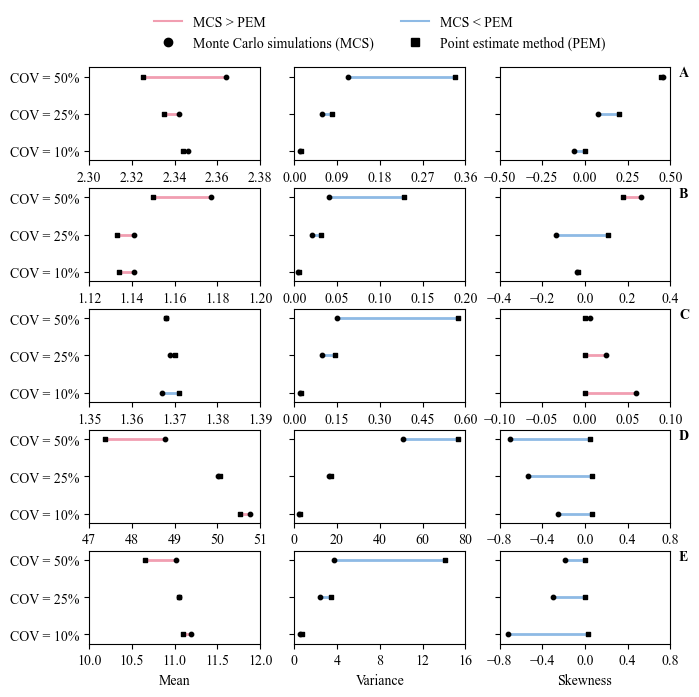

In [2]:
# plotting figure 3

from frontiers_yildizetal.analysis import uq
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import string

pem_mom = uq.Moments('synth').get_pem()
mcs_mom = uq.Moments('synth').get_mcs()

f_names = list(uq.Moments.funcs.keys())
scalars = list(pem_mom['mean'].keys())

diff_col = {}
for f in f_names:
    diff_col[f] = {}
    for s in scalars:
        x1 = pem_mom[f][s]
        x2 = mcs_mom[f][s]
        diff_col[f][s] = ['#F19EB1' if (y - x) > 0 else '#8EBAE5' for x, y in zip(x1, x2)]

locs = [1, 2, 3]
xlimits = (
    (2.3, 2.38),
    (0, 0.36),
    (-0.5, 0.5),
    (1.12, 1.20),
    (0, 0.2),
    (-0.4, 0.4),
    (1.35, 1.39),
    (0, 0.6),
    (-0.1, 0.1),
    (47, 51),
    (0, 80),
    (-0.8, 0.8),
    (10, 12),
    (0, 16),
    (-0.8, 0.8),
)
letters = list(string.ascii_uppercase)

fig, axs = plt.subplots(5, 3)
axs = axs.ravel()

for i, f in enumerate(f_names):
    for j, s in enumerate(scalars):
        axs[i + 3 * j].scatter(mcs_mom[f][s], locs, color='k', marker='o', s=10)
        axs[i + 3 * j].scatter(pem_mom[f][s], locs, color='k', marker='s', s=10)
        axs[i + 3 * j].hlines(
            y=locs,
            xmin=mcs_mom[f][s],
            xmax=pem_mom[f][s],
            color=diff_col[f][s],
            zorder=0,
            linewidth=2,
        )
        axs[i + 3 * j].set_ylim(0.75, 3.25)
        axs[i + 3 * j].set_yticks((1, 2, 3))
        axs[i + 3 * j].set_xlim(xlimits[i + 3 * j])
        axs[i + 3 * j].set_xticks(np.linspace(xlimits[i + 3 * j][0], xlimits[i + 3 * j][1], 5))
        if i == 0:
            axs[i + 3 * j].set_yticklabels(('COV = 10%', 'COV = 25%', 'COV = 50%'))
        else:
            axs[i + 3 * j].set_yticklabels([])
        if i == 2:
            axs[i + 3 * j].text(1.1 * xlimits[i + 3 * j][1], 3, letters[j], weight='bold')

axs[1].legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, frameon=False, fancybox=False
)
axs[1].legend(
    [
        Line2D([0], [0], color='#F19EB1'),
        Line2D([0], [0], marker='o', color='k', lw=0),
        Line2D([0], [0], color='#8EBAE5'),
        Line2D([0], [0], marker='s', color='k', lw=0),
    ],
    ['MCS > PEM', 'Monte Carlo simulations (MCS)', 'MCS < PEM', 'Point estimate method (PEM)'],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.7),
    ncol=2,
    frameon=False,
    fancybox=False,
)

axs[12].set_xlabel('Mean')
axs[13].set_xlabel('Variance')
axs[14].set_xlabel('Skewness')

plt.rcParams['figure.figsize'] = [18 / 2.54, 18 / 2.54]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)

**Figure 3:** Three moments (mean, variance and skewness) of (A) impact area (in x$10^6 m^2$), (B) deposit area (in x $10^6 m^2$), (C) deposit volume (in x106 m3), (D) maximum flow velocity (in m/s) and (E) maximum flow height (in m) at (x,y)= (1000, 2000) obtained from synthetic case with Monte Carlo simulations (MCS) and point estimate method (PEM).

Similar to PEM, MCS at all $COV$ produced similar mean values and increasing variance with increasing $COV$ for all scalar outputs. No overall trend can be observed in skewness of the outputs generated via MCS. If both techniques are compared, no significant difference is present in mean values. PEM produced higher variances especially at the highest $COV$, while - similar to previous comparisons - no generalisations can be made for skewness. It should be noted that there is a change from a slightly positive skewness to negative skewness for $v_{max}$ and $h_{max}$, if the method is switched from PEM to MCS. Other scalar outputs had rather arbitrary changes between methods, even though slightly lower values are observed for impact area and deposit area.

Figure 4 presents three moments of the same scalar outputs from Acheron rock avalanche. Similar patterns to data from synthetic case are observed in figure 4. Mean values of the outputs are similar between different methods and levels of $COV$. Variance increases in both methods with increasing $COV$, while the values obtained from MCS is lower than those from PEM.

IA calculated.
DA calculated.
DV calculated.
vmax extracted.
hmax extracted.
IA calculated.
DA calculated.
DV calculated.
vmax extracted.
hmax extracted.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


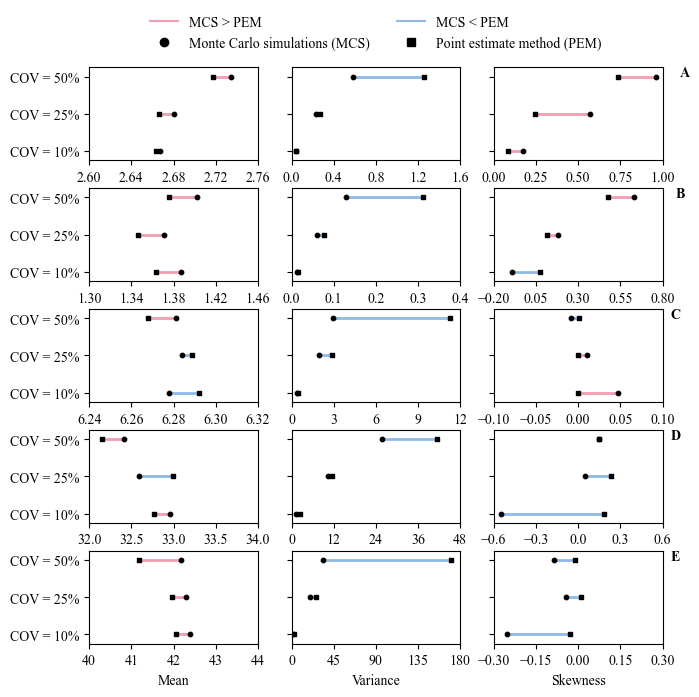

In [3]:
# plotting figure 4

from frontiers_yildizetal.analysis import uq
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import string

pem_mom = uq.Moments('acheron').get_pem()
mcs_mom = uq.Moments('acheron').get_mcs()

f_names = list(uq.Moments.funcs.keys())
scalars = list(pem_mom['mean'].keys())

diff_col = {}
for f in f_names:
    diff_col[f] = {}
    for s in scalars:
        x1 = pem_mom[f][s]
        x2 = mcs_mom[f][s]
        diff_col[f][s] = ['#F19EB1' if (y - x) > 0 else '#8EBAE5' for x, y in zip(x1, x2)]

locs = [1, 2, 3]
xlimits = (
    (2.6, 2.76),
    (0, 1.6),
    (0, 1),
    (1.3, 1.46),
    (0, 0.4),
    (-0.2, 0.8),
    (6.24, 6.32),
    (0, 12),
    (-0.1, 0.1),
    (32, 34),
    (0, 48),
    (-0.6, 0.6),
    (40, 44),
    (0, 180),
    (-0.3, 0.3),
)
letters = list(string.ascii_uppercase)

fig, axs = plt.subplots(5, 3)
axs = axs.ravel()

for i, f in enumerate(f_names):
    for j, s in enumerate(scalars):
        axs[i + 3 * j].scatter(mcs_mom[f][s], locs, color='k', marker='o', s=10)
        axs[i + 3 * j].scatter(pem_mom[f][s], locs, color='k', marker='s', s=10)
        axs[i + 3 * j].hlines(
            y=locs,
            xmin=mcs_mom[f][s],
            xmax=pem_mom[f][s],
            color=diff_col[f][s],
            zorder=0,
            linewidth=2,
        )
        axs[i + 3 * j].set_ylim(0.75, 3.25)
        axs[i + 3 * j].set_yticks((1, 2, 3))
        axs[i + 3 * j].set_xlim(xlimits[i + 3 * j])
        axs[i + 3 * j].set_xticks(np.linspace(xlimits[i + 3 * j][0], xlimits[i + 3 * j][1], 5))
        if i == 0:
            axs[i + 3 * j].set_yticklabels(('COV = 10%', 'COV = 25%', 'COV = 50%'))
        else:
            axs[i + 3 * j].set_yticklabels([])
        if i == 2:
            axs[i + 3 * j].text(1.1 * xlimits[i + 3 * j][1], 3, letters[j], weight='bold')

axs[1].legend(
    loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, frameon=False, fancybox=False
)
axs[1].legend(
    [
        Line2D([0], [0], color='#F19EB1'),
        Line2D([0], [0], marker='o', color='k', lw=0),
        Line2D([0], [0], color='#8EBAE5'),
        Line2D([0], [0], marker='s', color='k', lw=0),
    ],
    ['MCS > PEM', 'Monte Carlo simulations (MCS)', 'MCS < PEM', 'Point estimate method (PEM)'],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.7),
    ncol=2,
    frameon=False,
    fancybox=False,
)

axs[12].set_xlabel('Mean')
axs[13].set_xlabel('Variance')
axs[14].set_xlabel('Skewness')

plt.rcParams['figure.figsize'] = [18 / 2.54, 18 / 2.54]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)

**Figure 4:** Three moments (mean, variance and skewness) of (A) impact area (in x $10^6 m^2$), (B) deposit area (in x $10^6 m^2$), (C) deposit volume (in x $10^6 m^3$), (D) maximum flow velocity (in m/s) and (E) maximum flow height (in m) at (x,y)= (1490100, 5204100) obtained from Acheron rock avalanche with Monte Carlo simulations (MCS) and point estimate method (PEM).

Figure 5 illustrates the synthetic case results of the MCS analysis at $COV$ of 50\% in terms of the five scalar outputs - the impact area, deposit area, deposit volume, $v_{max}$ and $h_{max}$ at $\left( x, y \right) = $ (1000, 2000). The first three columns show the relationships of the scalar outputs with respect to the three uncertain parameters. The last column shows the histograms of each scalar output. Figure 6 presents the corresponding results of Acheron rock avalanche. Observations from figures 5 and 6 can be generalised as follows:

- the impact area and deposit area decrease with increasing dry-Coulomb friction coefficient and increases with increasing release volume (see figures 5A - B and 6A - B),
- the deposit volume is proportional to the release volume and has almost no dependence on the dry-Coulomb and turbulent friction coefficients (see figures 5C and 6C),
- the point-wise maximum flow velocity decreases with increasing dry-Coulomb friction coefficient and has little dependence on the release volume (see figures 5D and 6D),
- the point-wise maximum flow height increases with increasing release volume and has little dependence on the dry-Coulomb and turbulent friction coefficient (see figures 5E and 6E).

Differences between the two cases can be noted as (1) the deposit area has a clear negative relationship with the dry-Coulomb friction coefficient in Acheron rock avalanche, but the trend is hardly visible for the synthetic case; (2) the point-wise maximum velocity increases with the turbulent friction coefficient in the synthetic case, but the relationship is vague in Acheron rock avalanche.

IA calculated.
DA calculated.
DV calculated.
vmax extracted.
hmax extracted.


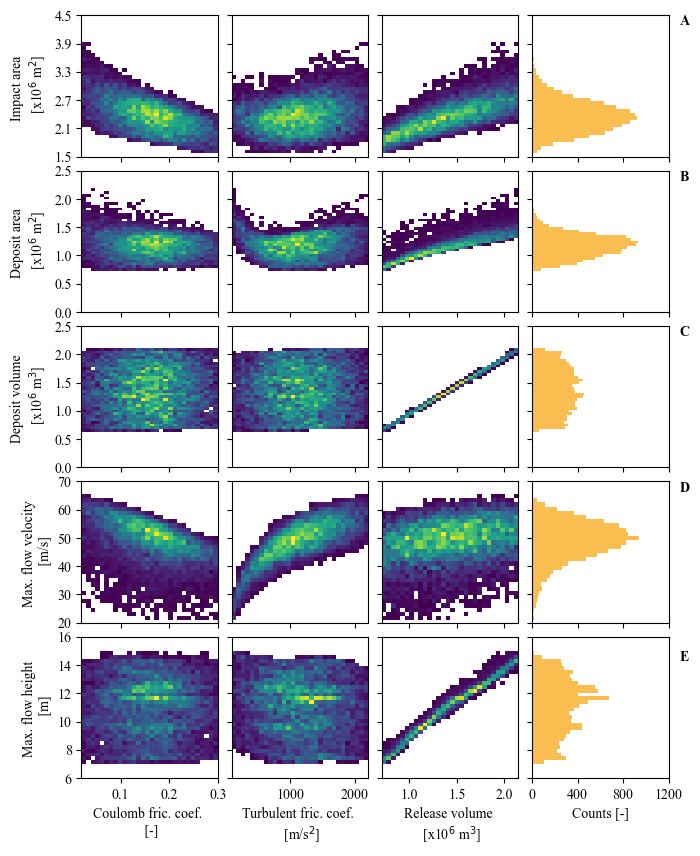

In [6]:
# plotting figure 5

from frontiers_yildizetal.emulators import ScalarEmulators
from frontiers_yildizetal.utilities import data
import matplotlib.pyplot as plt
import numpy as np

synth = ScalarEmulators('synth', threshold=0.1, loc_x=1000, loc_y=2000)
input_mcs3 = data.load_input('synth','mcs3')

scalars = list(synth.output.keys())

predicted = {}
for scalar in scalars:
    predicted[scalar] = synth.predict_scalar(scalar, input_mcs3)[0]

(
    fig,
    (
        (ax1, ax2, ax3, ax4),
        (ax5, ax6, ax7, ax8),
        (ax9, ax10, ax11, ax12),
        (ax13, ax14, ax15, ax16),
        (ax17, ax18, ax19, ax20),
    ),
) = plt.subplots(
    5, 4, figsize=(18 / 2.54, 22 / 2.54), sharex='col', sharey='row', squeeze=True
)

ax1.hist2d(input_mcs3[:, 0], predicted['ia'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax1.set_ylim(1.5, 4.5)
ax1.set_yticks(np.arange(1.5, 4.6, 0.6))
ax1.set_ylabel('Impact area \n [x10$^6$ m$^2$]')

ax2.hist2d(input_mcs3[:, 1], predicted['ia'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax2.set_ylim(1.5, 4.5)

ax3.hist2d(input_mcs3[:, 2], predicted['ia'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax3.set_ylim(1.5, 4.5)

ax4.hist(
    predicted['ia'], bins=30, color='#FABE50', label='Impact area', orientation='horizontal'
)
ax4.text(1300, 4.5, 'A', weight='bold', ha='left', va='top', fontsize=10)

ax5.hist2d(input_mcs3[:, 0], predicted['da'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax5.set_ylim(0, 2.5)
ax5.set_yticks(np.arange(0, 2.6, 0.5))
ax5.set_ylabel('Deposit area \n [x10$^6$ m$^2$]')

ax6.hist2d(input_mcs3[:, 1], predicted['da'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax6.set_ylim(0, 2.5)

ax7.hist2d(input_mcs3[:, 2], predicted['da'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax7.set_ylim(0, 2.5)

ax8.hist(
    predicted['da'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax8.set_xlim(0, 1200)
ax8.tick_params(labelbottom=False)
ax8.text(1300, 2.5, 'B', weight='bold', ha='left', va='top', fontsize=10)

ax9.hist2d(input_mcs3[:, 0], predicted['dv'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax9.set_ylim(0, 2.5)
ax9.set_yticks(np.arange(0, 2.6, 0.5))
ax9.set_ylabel('Deposit volume \n [x10$^6$ m$^3$]')

ax10.hist2d(input_mcs3[:, 1], predicted['dv'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax10.set_ylim(0, 2.5)

ax11.hist2d(input_mcs3[:, 2], predicted['dv'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax11.set_ylim(0, 2.5)

ax12.hist(
    predicted['dv'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax12.set_xlim(0, 1200)
ax12.set_xticks(np.arange(0, 1201, 400))
ax12.tick_params(labelbottom=False)
ax12.text(1300, 2.5, 'C', weight='bold', ha='left', va='top', fontsize=10)

ax13.hist2d(input_mcs3[:, 0], predicted['vmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax13.set_ylim(20, 70)
ax13.set_yticks(np.arange(20, 71, 10))
ax13.set_ylabel('Max. flow velocity \n [m/s]')

ax14.hist2d(input_mcs3[:, 1], predicted['vmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax14.set_ylim(20, 70)

ax15.hist2d(input_mcs3[:, 2], predicted['vmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax15.set_ylim(20, 70)

ax16.hist(
    predicted['vmax'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax16.set_xlim(0, 1200)
ax16.set_xticks(np.arange(0, 1201, 400))
ax16.tick_params(labelbottom=False)
ax16.text(1300, 70, 'D', weight='bold', ha='left', va='top', fontsize=10)

ax17.hist2d(input_mcs3[:, 0], predicted['hmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax17.set_ylim(6, 16)
ax17.set_yticks(np.arange(6, 17, 2))
ax17.set_xlim(0.02, 0.3)
ax17.set_ylabel('Max. flow height \n [m]')
ax17.set_xlabel('Coulomb fric. coef. \n [-]')

ax18.hist2d(input_mcs3[:, 1], predicted['hmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax18.set_ylim(6, 16)
ax18.set_xlim(100, 2200)
ax18.set_xlabel('Turbulent fric. coef. \n [m/s$^2$]')

ax19.hist2d(input_mcs3[:, 2], predicted['hmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax19.set_ylim(6, 16)
ax19.set_xlim(1.432 / 2, 1.432 * 1.5)
ax19.set_xlabel('Release volume \n [x10$^6$ m$^3$]')

ax20.hist(
    predicted['hmax'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax20.set_xlabel('Counts [-]')
ax20.set_xlim(0, 1200)
ax20.set_xticks(np.arange(0, 1201, 400))
ax20.tick_params(labelbottom=True)
ax20.text(1300, 15, 'E', weight='bold', ha='left', va='top', fontsize=10)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.tight_layout()

plt.subplots_adjust(hspace=0.1, wspace=0.1)


**Figure 5:** Relationships and histograms of (A) impact area, (B) deposit area, (C) deposit volume, (D) maximum flow velocity and (E) maximum flow height at (x,y)= (1000, 2000) from synthetic case with uncertain parameters used in the Monte Carlo analysis with coefficient of variation of 50%.

IA calculated.
DA calculated.
DV calculated.
vmax extracted.
hmax extracted.


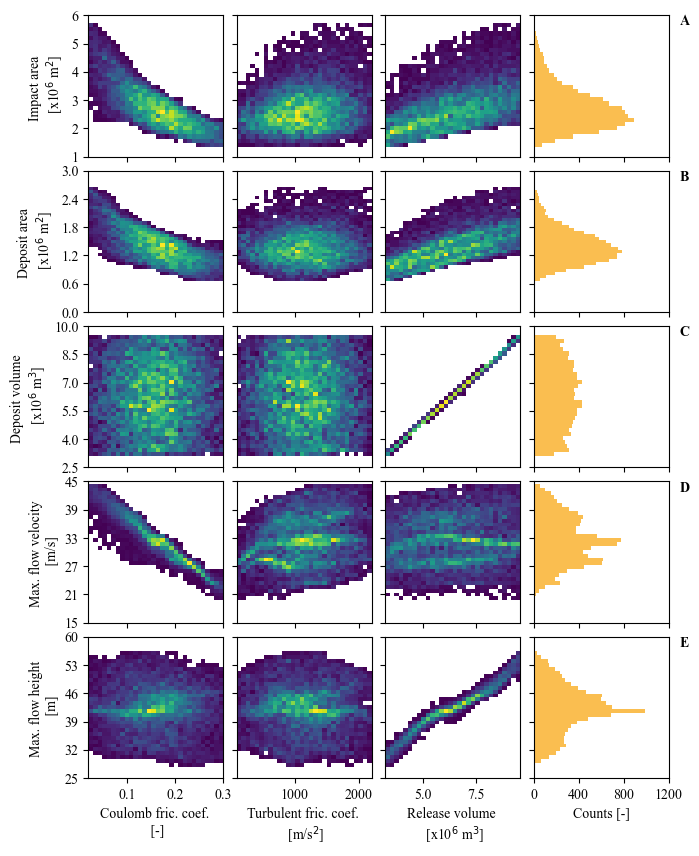

In [7]:
# plotting figure 6

from frontiers_yildizetal.emulators import ScalarEmulators
from frontiers_yildizetal.utilities import data
import matplotlib.pyplot as plt
import numpy as np

acheron = ScalarEmulators('acheron', threshold=0.1, loc_x=1490100, loc_y=5204100)
input_mcs3 = data.load_input('acheron','mcs3')

scalars = list(acheron.output.keys())

predicted = {}
for scalar in scalars:
    predicted[scalar] = acheron.predict_scalar(scalar, input_mcs3)[0]

(
    fig,
    (
        (ax1, ax2, ax3, ax4),
        (ax5, ax6, ax7, ax8),
        (ax9, ax10, ax11, ax12),
        (ax13, ax14, ax15, ax16),
        (ax17, ax18, ax19, ax20),
    ),
) = plt.subplots(
    5, 4, figsize=(18 / 2.54, 22 / 2.54), sharex='col', sharey='row', squeeze=True
)

ax1.hist2d(input_mcs3[:, 0], predicted['ia'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax1.set_ylim(1, 6)
ax1.set_yticks(np.arange(1, 6.1, 1))
ax1.set_ylabel('Impact area \n [x10$^6$ m$^2$]')

ax2.hist2d(input_mcs3[:, 1], predicted['ia'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax2.set_ylim(1, 6)

ax3.hist2d(input_mcs3[:, 2], predicted['ia'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax3.set_ylim(1, 6)

ax4.hist(
    predicted['ia'], bins=30, color='#FABE50', label='Impact area', orientation='horizontal'
)
ax4.text(1300, 6, 'A', weight='bold', ha='left', va='top', fontsize=10)

ax5.hist2d(input_mcs3[:, 0], predicted['da'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax5.set_ylim(0, 3)
ax5.set_yticks(np.arange(0, 3.1, 0.6))
ax5.set_ylabel('Deposit area \n [x10$^6$ m$^2$]')

ax6.hist2d(input_mcs3[:, 1], predicted['da'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax6.set_ylim(0, 3)

ax7.hist2d(input_mcs3[:, 2], predicted['da'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax7.set_ylim(0, 3)

ax8.hist(
    predicted['da'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax8.set_xlim(0, 1200)
ax8.tick_params(labelbottom=False)
ax8.text(1300, 3, 'B', weight='bold', ha='left', va='top', fontsize=10)

ax9.hist2d(input_mcs3[:, 0], predicted['dv'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax9.set_ylim(2.5, 10)
ax9.set_yticks(np.arange(2.5, 10.1, 1.5))
ax9.set_ylabel('Deposit volume \n [x10$^6$ m$^3$]')

ax10.hist2d(input_mcs3[:, 1], predicted['dv'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax10.set_ylim(2.5, 10)

ax11.hist2d(input_mcs3[:, 2], predicted['dv'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax11.set_ylim(2.5, 10)

ax12.hist(
    predicted['dv'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax12.set_xlim(0, 1200)
ax12.set_xticks(np.arange(0, 1201, 400))
ax12.tick_params(labelbottom=False)
ax12.text(1300, 10, 'C', weight='bold', ha='left', va='top', fontsize=10)

ax13.hist2d(input_mcs3[:, 0], predicted['vmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax13.set_ylim(15, 45)
ax13.set_yticks(np.arange(15, 46, 6))
ax13.set_ylabel('Max. flow velocity \n [m/s]')

ax14.hist2d(input_mcs3[:, 1], predicted['vmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax14.set_ylim(15, 45)

ax15.hist2d(input_mcs3[:, 2], predicted['vmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax15.set_ylim(15, 45)

ax16.hist(
    predicted['vmax'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax16.set_xlim(0, 1200)
ax16.set_xticks(np.arange(0, 1201, 400))
ax16.tick_params(labelbottom=False)
ax16.text(1300, 45, 'D', weight='bold', ha='left', va='top', fontsize=10)

ax17.hist2d(input_mcs3[:, 0], predicted['hmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax17.set_ylim(25, 60)
ax17.set_yticks(np.arange(25, 61, 7))
ax17.set_xlim(0.02, 0.3)
ax17.set_ylabel('Max. flow height \n [m]')
ax17.set_xlabel('Coulomb fric. coef. \n [-]')

ax18.hist2d(input_mcs3[:, 1], predicted['hmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax18.set_ylim(25, 60)
ax18.set_xlim(100, 2200)
ax18.set_xlabel('Turbulent fric. coef. \n [m/s$^2$]')

ax19.hist2d(input_mcs3[:, 2], predicted['hmax'], cmap='viridis', cmin=1, cmax=3000, bins=30)
ax19.set_ylim(25, 60)
ax19.set_xlim(6.4 / 2, 6.4 * 1.5)
ax19.set_xlabel('Release volume \n [x10$^6$ m$^3$]')

ax20.hist(
    predicted['hmax'], bins=30, color='#FABE50', label='Deposit area', orientation='horizontal'
)
ax20.set_xlabel('Counts [-]')
ax20.set_xlim(0, 1200)
ax20.set_xticks(np.arange(0, 1201, 400))
ax20.tick_params(labelbottom=True)
ax20.text(1300, 60, 'E', weight='bold', ha='left', va='top', fontsize=10)

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.tight_layout()

plt.subplots_adjust(hspace=0.1, wspace=0.1)

**Figure 6:** Relationships and histograms of (A) impact area, (B) deposit area, (C) deposit volume, (D) maximum flow velocity and (E) maximum flow height at (x,y)= (1490100, 5204100) from Acheron rock avalanche with uncertain parameters used in the Monte Carlo analysis with coefficient of variation of 50%.

Figures 7 and 8 show the comparison of spatial distribution of maximum flow height from synthetic case and Acheron rock avalanche, respectively. Results given in the figures, mean and standard deviation of $h_{max}$ in each cell as well as their differences, are from the PEM and MCS analyses conducted at $COV = 50\%$. A visual comparison of mean values (See figures 7A - B, and 8A - B) look nearly identical, but the difference map shows that flow heights at the central section of the flow path in both cases are higher in MCS analysis, while the edges of the flow path have higher flow heights in the PEM analysis. Similar to the results in figures 3 and 4, MCS produced lower standard deviation than PEM at the majority of cells, i.e approximately 200 cells out of 6600 for synthetic case, and 830 cells out of 9800 cells for Acheron rock avalanche.

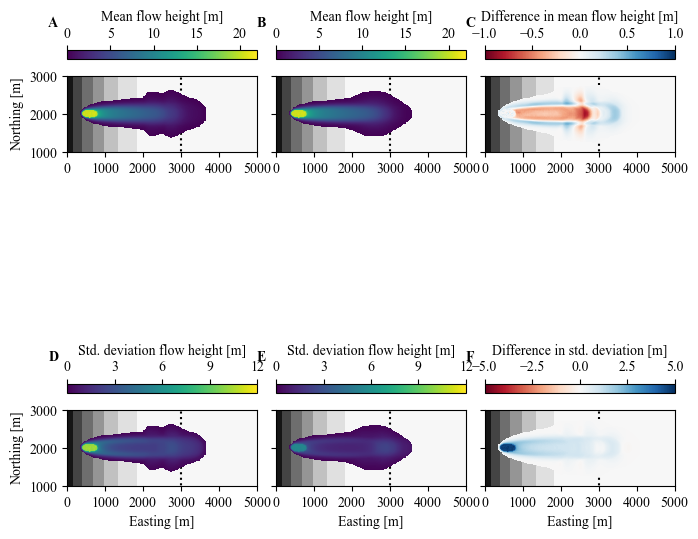

In [8]:
# plotting figure 7

from frontiers_yildizetal.ravaflow import Simulations
from frontiers_yildizetal.emulators import VectorEmulators
from frontiers_yildizetal.utilities import data
from pkg_resources import resource_filename
import matplotlib.pyplot as plt
import numpy as np
import rasterio

path = 'files/raster/elev.tif'
dem_path = resource_filename('frontiers_yildizetal', path)
with rasterio.open(dem_path, 'r') as src:
    dem = src.read(1)

synth = VectorEmulators('synth', qoi='hmax', threshold=0.1)
input_mcs3 = data.load_input('synth','mcs3')

mcs3_mean, mcs3_sd = synth.predict_vector(input_mcs3)
mcs3_mean_ma = np.ma.masked_where(mcs3_mean < 0.1, mcs3_mean, copy=True)
mcs3_sd_ma = np.ma.masked_where(mcs3_mean < 0.1, mcs3_sd, copy=True)

synth_pem = Simulations('synth_pem').create_vector(
    qoi='hmax', threshold=0.1, valid_cols=synth.valid_cols
)

pem3_mean = np.zeros((1, synth.rows * synth.cols))
pem3_mean[:,synth.valid_cols.nonzero()] = synth_pem[0][16:24].mean(axis=0)
pem3_mean = pem3_mean.reshape(synth.rows, synth.cols)
pem3_mean_ma = np.ma.masked_where(pem3_mean < 0.1, pem3_mean, copy=True)

pem3_sd = np.zeros((1, synth.rows * synth.cols))
pem3_sd[:,synth.valid_cols.nonzero()] = synth_pem[0][16:24].std(axis=0)
pem3_sd = pem3_sd.reshape(synth.rows, synth.cols)
pem3_sd_ma = np.ma.masked_where(pem3_mean < 0.1, pem3_sd, copy=True)

diff_mean = pem3_mean - mcs3_mean
diff_sd = pem3_sd - mcs3_sd

diff_mean_ma = np.ma.masked_where(diff_mean == 0, diff_mean, copy=True)
diff_sd_ma = np.ma.masked_where(diff_sd == 0, diff_sd, copy=True)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 1]}
)

ax1.contourf(dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400)
ax1.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyles='dotted')
c1 = ax1.imshow(
    pem3_mean_ma, cmap='viridis', extent=[0, 5000, 0, 4000], zorder=1, vmin=0, vmax=22
)
fig.colorbar(
    c1,
    ax=ax1,
    location='top',
    orientation='horizontal',
    label='Mean flow height [m]',
    ticks=np.arange(0, 21, 5),
)
ax1.set_ylabel('Northing [m]')
ax1.set_xticks(np.arange(0, 5001, 1000))
ax1.set_yticks(np.arange(0, 5001, 1000))
ax1.set_xlim(0, 5000)
ax1.set_ylim(1000, 3000)
ax1.text(-500, 4300, 'A', weight='bold')

ax2.contourf(dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400)
ax2.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyle='dotted')
c2 = ax2.imshow(mcs3_mean_ma, cmap='viridis', extent=[0, 5000, 0, 4000], vmin=0, vmax=22)
fig.colorbar(
    c2,
    ax=ax2,
    location='top',
    orientation='horizontal',
    label='Mean flow height [m]',
    ticks=np.arange(0, 21, 5),
)
ax2.set_xticks(np.arange(0, 5001, 1000))
ax2.set_yticks(np.arange(0, 5001, 1000), labels=None)
ax2.set_xlim(0, 5000)
ax2.set_ylim(1000, 3000)
ax2.text(-500, 4300, 'B', weight='bold')
ax2.axes.get_yaxis().set_ticklabels([])

ax3.contourf(dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400)
ax3.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyle='dotted')
c3 = ax3.imshow(diff_mean_ma, cmap='RdBu', extent=[0, 5000, 0, 4000], vmin=-1, vmax=1)
fig.colorbar(
    c3,
    ax=ax3,
    location='top',
    orientation='horizontal',
    label='Difference in mean flow height [m]',
)
ax3.set_xticks(np.arange(0, 5001, 1000))
ax3.set_yticks(np.arange(0, 5001, 1000), labels=None)
ax3.set_xlim(0, 5000)
ax3.set_ylim(1000, 3000)
ax3.axes.get_yaxis().set_ticklabels([])
ax3.text(-500, 4300, 'C', weight='bold')

ax4.contourf(dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400)
ax4.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyles='dotted')
c4 = ax4.imshow(
    pem3_sd_ma, cmap='viridis', extent=[0, 5000, 0, 4000], zorder=1, vmin=0, vmax=12
)
fig.colorbar(
    c4,
    ax=ax4,
    location='top',
    orientation='horizontal',
    label='Std. deviation flow height [m]',
    ticks=np.arange(0, 13, 3),
)
ax4.set_xlabel('Easting [m]')
ax4.set_ylabel('Northing [m]')
ax4.set_xticks(np.arange(0, 5001, 1000))
ax4.set_yticks(np.arange(0, 5001, 1000))
ax4.set_xlim(0, 5000)
ax4.set_ylim(1000, 3000)
ax4.text(-500, 4300, 'D', weight='bold')

ax5.contourf(dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400)
ax5.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyle='dotted')
c5 = ax5.imshow(mcs3_sd_ma, cmap='viridis', extent=[0, 5000, 0, 4000], vmin=0, vmax=12)
fig.colorbar(
    c5,
    ax=ax5,
    location='top',
    orientation='horizontal',
    label='Std. deviation flow height [m]',
    ticks=np.arange(0, 13, 3),
)
ax5.set_xlabel('Easting [m]')
ax5.set_xticks(np.arange(0, 5001, 1000))
ax5.set_yticks(np.arange(0, 5001, 1000), labels=None)
ax5.set_xlim(0, 5000)
ax5.set_ylim(1000, 3000)
ax5.axes.get_yaxis().set_ticklabels([])
ax5.text(-500, 4300, 'E', weight='bold')

ax6.contourf(dem, extent=[0, 5000, 0, 4000], cmap='Greys', zorder=0, vmin=0, vmax=1400)
ax6.vlines(x=3000, ymin=0, ymax=4000, zorder=0, color='k', linestyle='dotted')
c6 = ax6.imshow(diff_sd_ma, cmap='RdBu', extent=[0, 5000, 0, 4000], vmin=-5, vmax=5)
fig.colorbar(
    c6,
    ax=ax6,
    location='top',
    orientation='horizontal',
    label='Difference in std. deviation [m]',
)
ax6.set_xlabel('Easting [m]')
ax6.set_xticks(np.arange(0, 5001, 1000))
ax6.set_yticks(np.arange(0, 5001, 1000), labels=None)
ax6.set_xlim(0, 5000)
ax6.set_ylim(1000, 3000)
ax6.axes.get_yaxis().set_ticklabels([])
ax6.text(-500, 4300, 'F', weight='bold')

plt.rcParams['figure.figsize'] = [18 / 2.54, 10 / 2.54]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.tight_layout()

plt.subplots_adjust(hspace=0, wspace=0.1)

fig.set_rasterized(True)
ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)
ax4.set_rasterized(True)
ax5.set_rasterized(True)
ax6.set_rasterized(True)

**Figure 7:** Spatial distribution of mean and standard deviations of maximum flow height (hmax) from synthetic case obtained with (A, D) Point Estimate Method (PEM) and (B, E) Monte Carlo Simulations (MCS) at 50% coefficient of variation. Differences of (C) mean value and (F) standard deviation are plotted by subtracting MCS results from PEM results.

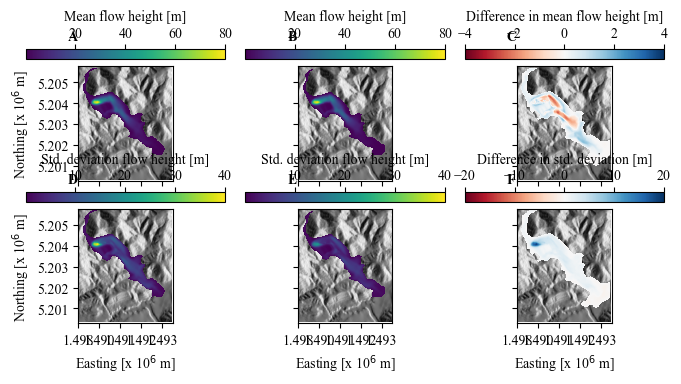

In [9]:
# plotting figure 8

from frontiers_yildizetal.ravaflow import Simulations
from frontiers_yildizetal.emulators import VectorEmulators
from frontiers_yildizetal.utilities import data
from pkg_resources import resource_filename
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import plotting_extent

path = 'files/raster/hillshade_acheron.tif'
hill_path = resource_filename('frontiers_yildizetal', path)
with rasterio.open(hill_path, 'r') as hill:
    hill_arr = hill.read(1)
hill_ma = np.ma.masked_where(hill_arr < -30000, hill_arr, copy=True)

ac = VectorEmulators('acheron', qoi='hmax', threshold=0.1)
input_mcs3 = data.load_input('acheron','mcs3')

mcs3_mean, mcs3_sd = ac.predict_vector(input_mcs3)
mcs3_mean_ma = np.ma.masked_where(mcs3_mean < 0.1, mcs3_mean, copy=True)
mcs3_sd_ma = np.ma.masked_where(mcs3_mean < 0.1, mcs3_sd, copy=True)

ac_pem = Simulations('acheron_pem').create_vector(
    qoi='hmax', threshold=0.1, valid_cols=ac.valid_cols
)

pem3_mean = np.zeros((1, ac.rows * ac.cols))
pem3_mean[:,ac.valid_cols.nonzero()] = ac_pem[0][16:24].mean(axis=0)
pem3_mean = pem3_mean.reshape(ac.rows, ac.cols)
pem3_mean_ma = np.ma.masked_where(pem3_mean < 0.1, pem3_mean, copy=True)

pem3_sd = np.zeros((1, ac.rows * ac.cols))
pem3_sd[:,ac.valid_cols.nonzero()] = ac_pem[0][16:24].std(axis=0)
pem3_sd = pem3_sd.reshape(ac.rows, ac.cols)
pem3_sd_ma = np.ma.masked_where(pem3_mean < 0.1, pem3_sd, copy=True)

diff_mean = pem3_mean - mcs3_mean
diff_sd = pem3_sd - mcs3_sd

diff_mean_ma = np.ma.masked_where(diff_mean == 0, diff_mean, copy=True)
diff_sd_ma = np.ma.masked_where(diff_sd == 0, diff_sd, copy=True)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, gridspec_kw={'width_ratios': [1, 1, 1], 'height_ratios': [1, 1]}
)

ax1.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c1 = ax1.imshow(
    pem3_mean_ma, cmap='viridis', extent=plotting_extent(hill), zorder=1, vmin=0.1, vmax=80
)
fig.colorbar(
    c1, ax=ax1, location='top', orientation='horizontal', label='Mean flow height [m]'
)
ax1.set_ylabel('Northing [x 10$^6$ m]')
ax1.set_xticks(ticks=np.arange(1489000, 1493600, 1000), labels=None)
ax1.set_yticks(
    ticks=np.arange(5201000, 5205001, 1000), labels=[5.201, 5.202, 5.203, 5.204, 5.205]
)
ax1.text(1488500, 5207000, 'A', weight='bold')
ax1.axes.get_xaxis().set_ticklabels([])

ax2.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c2 = ax2.imshow(mcs3_mean_ma, cmap='viridis', extent=plotting_extent(hill), vmin=0.1, vmax=80)
fig.colorbar(
    c2, ax=ax2, location='top', orientation='horizontal', label='Mean flow height [m]'
)
ax2.set_xticks(
    ticks=np.arange(1489000, 1493600, 1000), labels=[1.498, '1.490', 1.491, 1.492, 1.493]
)
ax2.set_yticks(
    ticks=np.arange(5201000, 5205001, 1000), labels=[5.201, 5.202, 5.203, 5.204, 5.205]
)
ax2.text(1488500, 5207000, 'B', weight='bold')
ax2.axes.get_yaxis().set_ticklabels([])
ax2.axes.get_xaxis().set_ticklabels([])

ax3.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c3 = ax3.imshow(diff_mean_ma, cmap='RdBu', extent=plotting_extent(hill), vmin=-4, vmax=4)
fig.colorbar(
    c3,
    ax=ax3,
    location='top',
    orientation='horizontal',
    label='Difference in mean flow height [m]',
)
ax3.set_xticks(
    ticks=np.arange(1489000, 1493600, 1000), labels=[1.498, '1.490', 1.491, 1.492, 1.493]
)
ax3.set_yticks(
    ticks=np.arange(5201000, 5205001, 1000), labels=[5.201, 5.202, 5.203, 5.204, 5.205]
)
ax3.text(1488500, 5207000, 'C', weight='bold')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_xaxis().set_ticklabels([])

ax4.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c4 = ax4.imshow(
    pem3_sd_ma, cmap='viridis', extent=plotting_extent(hill), zorder=1, vmin=0.1, vmax=40
)
fig.colorbar(
    c4,
    ax=ax4,
    location='top',
    orientation='horizontal',
    label='Std. deviation flow height [m]',
)
ax4.set_xticks(
    ticks=np.arange(1489000, 1493600, 1000), labels=[1.498, '1.490', 1.491, 1.492, 1.493]
)
ax4.set_yticks(
    ticks=np.arange(5201000, 5205001, 1000), labels=[5.201, 5.202, 5.203, 5.204, 5.205]
)
ax4.text(1488500, 5207000, 'D', weight='bold')
ax4.set_xlabel('Easting [x 10$^6$ m]')
ax4.set_ylabel('Northing [x 10$^6$ m]')

ax5.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c5 = ax5.imshow(mcs3_sd_ma, cmap='viridis', extent=plotting_extent(hill), vmin=0.1, vmax=40)
fig.colorbar(
    c5,
    ax=ax5,
    location='top',
    orientation='horizontal',
    label='Std. deviation flow height [m]',
)
ax5.set_xticks(
    ticks=np.arange(1489000, 1493600, 1000), labels=[1.498, '1.490', 1.491, 1.492, 1.493]
)
ax5.set_yticks(
    ticks=np.arange(5201000, 5205001, 1000), labels=[5.201, 5.202, 5.203, 5.204, 5.205]
)
ax5.text(1488500, 5207000, 'E', weight='bold')
ax5.axes.get_yaxis().set_ticklabels([])
ax5.set_xlabel('Easting [x 10$^6$ m]')

ax6.imshow(hill_ma, cmap='Greys', extent=plotting_extent(hill))
c6 = ax6.imshow(diff_sd_ma, cmap='RdBu', extent=plotting_extent(hill), vmin=-20, vmax=20)
fig.colorbar(
    c6,
    ax=ax6,
    location='top',
    orientation='horizontal',
    label='Difference in std. deviation [m]',
)
ax6.set_xticks(
    ticks=np.arange(1489000, 1493600, 1000), labels=[1.498, '1.490', 1.491, 1.492, 1.493]
)
ax6.set_yticks(
    ticks=np.arange(5201000, 5205001, 1000), labels=[5.201, 5.202, 5.203, 5.204, 5.205]
)
ax6.text(1488500, 5207000, 'F', weight='bold')
ax6.axes.get_yaxis().set_ticklabels([])
ax6.set_xlabel('Easting [x 10$^6$ m]')

plt.rcParams['figure.figsize'] = [18 / 2.54, 18 / 2.54]
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.tight_layout()

plt.subplots_adjust(hspace=0, wspace=0.1)

**Figure 8:** Spatial distribution of mean and standard deviations of maximum flow height (hmax) from Acheron rock avalanche obtained with (A, D) Point Estimate Method (PEM) and (B, E) Monte Carlo Simulations (MCS) at 50% coefficient of variation. Differences of (C) mean value and (F) standard deviation are plotted by subtracting MCS results from PEM results.

## Discussion

Risk for a single landslide scenario has three main components: the landslide hazard, the exposure of the elements at risk, and their vulnerability. Conducting a quantitative risk analysis enables the researchers or practitioners to obtain the probability of a given level of loss and the corresponding uncertainties of these components ([Eidsvig et al., 2014](https://doi.org/10.1016/j.enggeo.2014.08.006),[Corominas et al., 2014](https://doi.org/10.1007/s10064-013-0538-8)). The hazard in a model-based landslide risk assessment is generally evaluated by simulating various scenarios with an underlying physics-based computational model. A probabilistic approach to this assessment and the quantification of associated uncertainty inevitably create a computational bottleneck - especially for large-scale applications ([Strauch et al., 2018](https://doi.org/10.5194/esurf-6-49-2018); [Jiang et al., 2022](https://doi.org/10.1016/j.compgeo.2021.104498)). One can opt for a simple technique to quantify uncertainty, i.e. PEM in this study, to reduce the number of simulations required, or use a technique necessitating high number of simulations, for instance MCS techniques.

The computational challenge of MCS has been well-recognised in the field of landslide modelling, which results from the large number of model realisations at randomly selected input values ([Dalbey et al., 2008](https://doi.org/10.1029/2006JB004471), [McDougall, 2017](https://doi.org/10.1139/cgj-2016-0104)). MCS can be very computationally intensive, since it typically requires tens of thousands of model runs to achieve reasonable accuracy ([Salciarini et al., 2017](https://doi.org/10.1007/s10346-017-0812-0)). This is often not feasible in model-based landslide risk assessment, as a single model run may take minutes to hours. A solution to overcome this problem has been demonstrated in this study by utilising recent development of GP emulation ([Gu and Berger, 2016](https://doi.org/10.1214/16-AOAS934); [Gu et al., 2018](https://doi.org/10.1214/17-AOS1648); [Gu et al., 2019](https://doi.org/10.32614/RJ-2019-011)). GP emulators are built for each case based on only 100 model runs. Then, MCS with 10000 randomly generated inputs is conducted using the emulators, which means no further model runs are needed. Moreover, diagnostics of built GP emulators are analysed to evaluate their performance. High $R^2$ values and low $MAPE$s and $nRMSE$s (See table 2) suggests that the scalar emulators can be used with confidence for predictions of a singular output from an input parameter combination. All $P_\text{CI}(95\%)$ values for the vector emulators are close to 95\%, which justify their usage as a surrogate to the computational model ([Gu et al., 2019](https://doi.org/10.32614/RJ-2019-011)). The corresponding results of GP emulation-based MCS are therefore close to results of a classical MCS, but the computational time is significantly reduced by introducing GP emulation. This demonstrates the applicability of GP emulation for uncertainty quantification of landslide run-out models. A similar methodology applied to landslide generated waves was also found promising to perform probabilistic hazard analysis based on computationally intensive models ([Snelling et al., 2020](https://doi.org/10.3390/w12020416)).

Comparative studies in landslide research showed that similar mean values of the QoI can obtained with PEM or MCS ([Przewlocki et al., 2019](https://doi.org/10.1088/1757-899X/471/4/042003); [Tsai et al., 2015](https://doi.org/10.1007/s12665-014-3696-5)). As shown in figures 3 and 4, when an aggregated (e.g. impact area, deposit area, deposit volume) or point-wise (velocity and height at a predetermined coordinate) output is calculated, PEM and MCS yielded similar expectancies (mean values) in this study. In addition, both PEM and MCS lead to similar variance values for relatively low COV, i.e. 10\% and 25\%. This implies that if one only aims at computing low-order moments in comparative topographic settings, PEM can achieve reasonable results ([Fanelli et al., 2018](https://doi.org/10.1201/9781315375007-93)). PEM is particularly computationally appealing for low-dimensional problems due to the requirement of $2^n$ realisations, where $n$ is the dimension of the input parameter space. However, as pointed out by [Christian and Baecher, 2002](https://doi.org/10.1002/nag.256), caution should be used in approximating skewness or other higher order moments based on PEM. This is supported by the large difference between PEM- and MCS-based skewness results as shown in figures 3 and 4. [Christian and Baecher, 2002](https://doi.org/10.1002/nag.256) also pointed out that the results deviate significantly, when the $COV$ of uncertain inputs is large, which is confirmed by the large difference between the variance computed by PEM and MCS in the cases of $COV=50\%$ as shown in figure 3 and 4. Comparing figure 3 and figure 4, it can be seen that the complexity of topography, which refers to the real topography of Acheron rock avalanche in comparison to the parabolic slope of the synthetic case, seems to have limited impact on the general trend of moments based on PEM and MCS, especially mean and variance. It may imply the transferability of the trends described above to different topographies.

When input uncertainty is high and the input parameter space is high-dimensional, MCS is clearly favourable over PEM to compute desired statistics of the output of interest. The benefit of GP-integrated MCS is that it can not only compute the desired statistics, but it also provides the PDF ([Marin and Mattos, 2020](https://doi.org/10.1080/17499518.2019.1633582)). [Cepeda et al. (2013)](https://www.cfms-sols.org/sites/default/files/Actes/2157-2160.pdf) recommends a stochastic approach for uncertainty quantification such as MCS to be part of the routine of any landslide hazard risk assessment, and [Hussin et al., 2012](https://doi.org/10.5194/nhess-12-3075-2012) denotes the frequency distributions of model outputs important as a first step to assess the spatial probability in future debris flow hazard assessments. The workflow of GP emulation-based uncertainty quantification in this study is therefore expected to improve landslide risk assessment. It should be noted that the number of model runs to train GP emulators are effected by the dimension of input parameter space even though the number of model runs of MCS is independent. Due to this limitation, the gain of computational efficiency by using GP emulation decreases with increasing dimension of input parameter space. If the dimension is too high, other emulation techniques or dimension reduction can be considered ([Liu and Guillas, 2017](https://doi.org/10.1137/16M1090648)).

Histograms plotted in figures 5 and 6 can be used to infer on the complexity of the output functions, see equation 9. Input parameters were assumed to be normally distributed in MCS analysis. It can be seen that the deposit volume (see figures 5C and 6C) is the only parameter that has the shape of the truncated normal distribution with nearly no skewness. Other scalar outputs result in skewed and even bi-modal distributions that clearly deviate from the initial Gaussian distribution of the corresponding input parameter. Both cases show a nearly perfect correlation between deposit and release volume with no effects of the friction coefficient indicating parameter-independent mass conservation. It should be noted that the deposit volume was calculated considering cells in which height exceeded 0.1 m at the last simulation time step. As there was no stopping criteria defined and no entrainment was considered, the deposit volume was nearly equal to the release volume. Highly linear function of deposit volume and release volume translates into the deposit volume having a Gaussian distribution, as the linear transformation of a Gaussian distribution is also a Gaussian distribution. However, the non-linearity of the other functions that can be used the express the scalar outputs - except deposit volume - results in distributions different than those of the input parameters. For example, [Cepeda et al. (2013)](https://www.cfms-sols.org/sites/default/files/Actes/2157-2160.pdf) fitted Gamma distributions for flow height and velocity in two different cases.

Patterns observed in figures 7C and 8C can be explained by analysing the effects of input variables on the general shape of the flow path. Hence, the simulation in a synthetic topography is an ideal example due to its simplicity. As explained in section 3.1 and shown in figure 1A, the flow path of the synthetic case can be described as a concentrated central flow superposed by lateral spread at the toe of the slope. It can be seen in figure 7A that the mean flow height has two pronounced *dents* in its spatial distribution obtained with PEM. These correspond to the initiation of the lateral spread at different configurations of the input variables are considered. More specifically, PEM analysis is run only at few discrete values in parameter space chosen at a distance of one standard deviation away from the mean. When the friction coefficient is chosen at a $COV=50\%$ with a mean of 0.16, PEM simulations are characterised by a lateral spread very early in the flow path, or a lateral spread that kicks in much further downstream. Therefore, the *dents* in the maximum flow height map (See figure 7A) is a direct consequence of the coarse discretisation of the parameter space in the PEM approach. In contrast, MCS yields a homogeneously distributed maximum flow height map at the toe of the slope as expected in this almost linear setting. As a consequence, flow heights at the upper sections of the lateral spread are higher in PEM, whereas MCS yields higher values at the mid-section of the lateral spread (See figure 7C).

To recognise patterns between the location ($x_{L}$) and the magnitude ($L_{max}$) of the maximum lateral spread with the input variables, linear regression analysis was conducted. Table 3 shows that the the location is controlled dominantly by the dry-Coulomb friction coefficient with a negative correlation, i.e. higher the friction coefficient earlier the lateral spread starts, and how much the flow spreads in $y$-axis is mostly controlled by the release volume, even though the friction coefficients affect to a certain extent.


## Conclusions

Uncertainty quantification is a computationally demanding task for designing and developing a model-based landslide risk assessment. Classical MCS is often computationally infeasible due to the large number of required forward evaluations of the computational model. It has been demonstrated that GP emulation-based MCS can greatly improve the computational efficiency which makes GP-integrated MCS applicable for landslide run-out modelling. One clear advantage of using GP emulation-based MCS is the ability to sample parameter uncertainty in a dense way, as evaluation time of the forward simulation is no longer a computational bottleneck. As a consequence, the output's probability distribution reflecting the propagated uncertainty is captured at high accuracy and provides additional information about skewness and possible multi-modality. In contrast to this PEM provides only limited information on the output's probability distribution. A comparative study between PEM and GP emulation-based MCS has been conducted based on the three moments of the probability distribution, i.e. mean, variance, and skewness. The simpler approach, PEM, yielded a similar expectancy values to GP emulation-based MCS. However, PEM and MCS differed in higher order moments, such as variances and skewness, hence also in the respective spatial distribution of the flow path, and the subsequent hazard map. This finding is of high practical relevance: While a computationally cheap PEM based workflow predicts the mean of a probabilistic landslide risk assessment well, it is in general cases not suitable to assess the reliability of the prediction, for instance in the sense of a probabilistic simulation's standard deviation. The latter requires a MCS approach, which often is computationally infeasible. GP-emulated MCS overcome this limitations by introducing a surrogate model trained based on an empirical error control. It can be suggested that highly uncertain and high-dimensional input parameter spaces, e.g. complex topographies, advanced material models, models with empirical parameters, inevitably requires an uncertainty quantification workflow that is able to account for non-Gaussian, potentially multi-modal distributions. It should be noted that the gain in compute time by using GP emulation critically depends on the computational effort needed to train the GP emulator. This means that computational resources significantly increase, as the dimension of the input parameter space increases. Alternative techniques will have to be incorporated if the input dimension is too high.
